In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Think Bayes example: mix of dice, probability of a random die being chosen given the observed sequence of rolls.
Similar to Beta-Bernoulli problem i.e. change posterior distribution on Beta given observed sequence (see Bayesian methods for Hackers)

In [2]:
d6 = pm.DiscreteUniform.dist(lower=1, upper=6)
d10 = pm.DiscreteUniform.dist(lower=1, upper=10)
coin = pm.Bernoulli.dist([0.5, 0.1])

In [3]:
pm.draw([coin, pm.math.where(coin, d10, d6)], 100)

[array([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        

In [4]:
y = pm.Binomial.dist(n=10, p=0.5)


In [5]:
pm.draw(y, 10)

array([3, 5, 7, 5, 5, 6, 4, 8, 7, 7])

In [6]:
with pm.Model() as cookie_model:
    coin = pm.Bernoulli('coin', 0.5)
    bag_1 = pm.Bernoulli('bag_1', 30/40)
    bag_2 = pm.Bernoulli('bag_2', 20/40)
    cookie = pm.Deterministic('cookie', pm.math.where(coin, bag_1, bag_2))
    # cookie = pm.Mixture('cookie', w=coin, components=[pm.Bernoulli.dist(30/40), pm.Bernoulli.dist(20/20)])


In [7]:
cookie_model

  coin ~ Bernoulli(0.5)
 bag_1 ~ Bernoulli(0.75)
 bag_2 ~ Bernoulli(0.5)
cookie ~ Deterministic(f(bag_2, bag_1, coin))

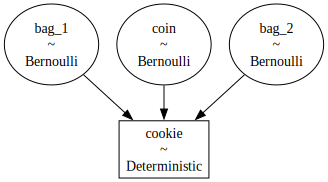

In [9]:
pm.model_to_graphviz(cookie_model)

In [10]:
with cookie_model:
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [coin, bag_1, bag_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [11]:
idata

Inference data with groups:
	> posterior

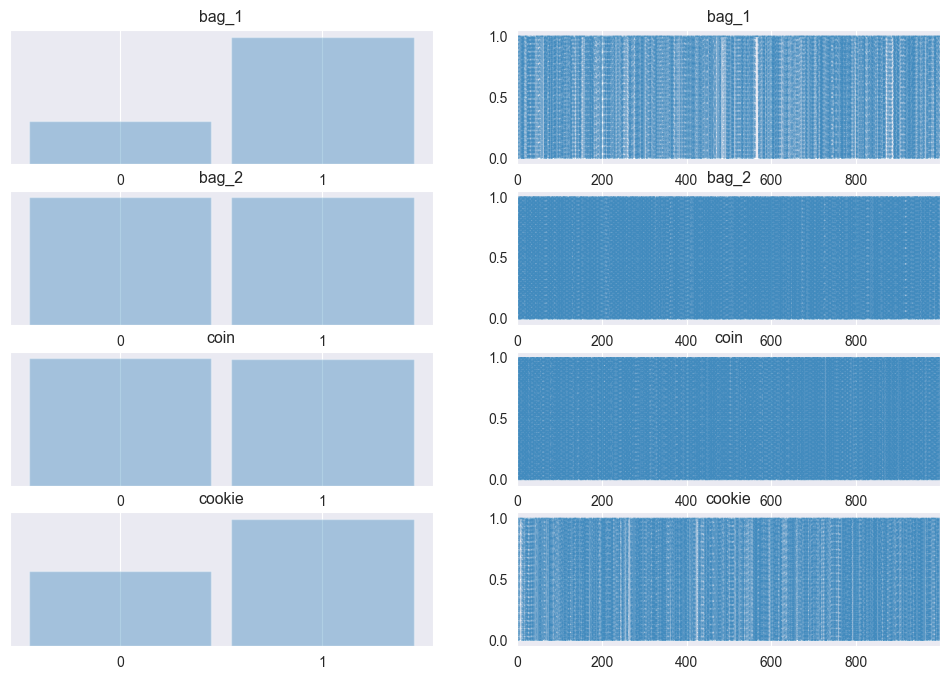

In [12]:
az.plot_trace(idata, combined=True);

In [14]:
with pm.Model() as cookie_model2:
    coin = pm.Bernoulli('coin', 0.5)
    p_vanilla = pm.math.where(coin, 20/40, 30/40)
    cookie = pm.Bernoulli('cookie', p_vanilla)
 

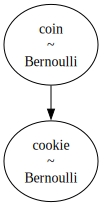

In [16]:
pm.model_to_graphviz(cookie_model2)

In [15]:
cookie_obs = [1]
# with pm.observe(cookie_model, {'cookie': cookie_obs}):
with cookie_model2:
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [coin, cookie]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


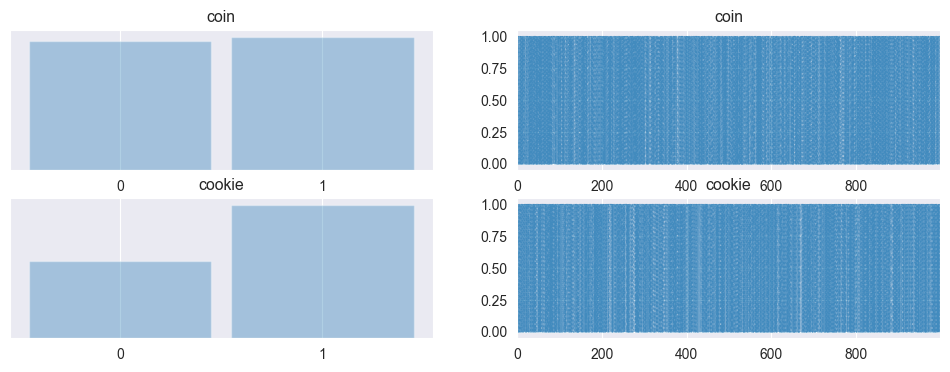

In [17]:
az.plot_trace(idata, combined=True);



In [18]:
cookie_obs = 1
with pm.observe(cookie_model2, {'cookie': cookie_obs}):
# with cookie_model2:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [coin]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


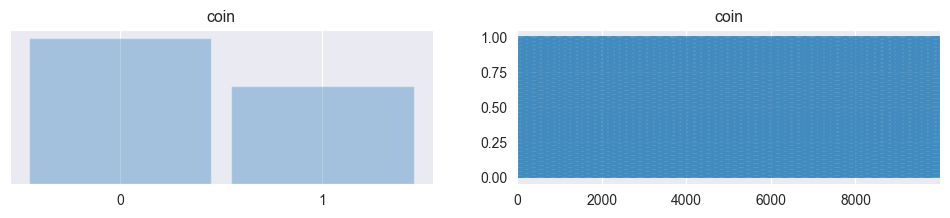

In [19]:
az.plot_trace(idata, combined=True);

In [22]:
idata.to_dataframe().iloc[:, -1].value_counts(normalize=True)

coin
0    0.5984
1    0.4016
Name: proportion, dtype: float64

Beta-binomial model

In [38]:
obs_dist = pm.Binomial.dist(n=1, p=0.7)
obs = pm.draw(obs_dist, 20)

In [53]:
with pm.Model() as bb_model:
    # Specify the prior distribution of unknown parameter
    theta = pm.Beta("theta", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=theta, observed=obs)

    # Sample from the posterior distribution
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


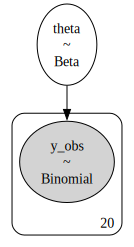

In [54]:
pm.model_to_graphviz(bb_model)

In [57]:
pred_dists = (pm.sample_prior_predictive(1000, bb_model, var_names=['y_obs']),
                  pm.sample_posterior_predictive(idata, bb_model, var_names=['theta', 'y_obs']))

Sampling: [theta, y_obs]
Sampling: [theta, y_obs]


Output()

In [73]:
pred_dists[1]

Inference data with groups:
	> posterior_predictive
	> observed_data

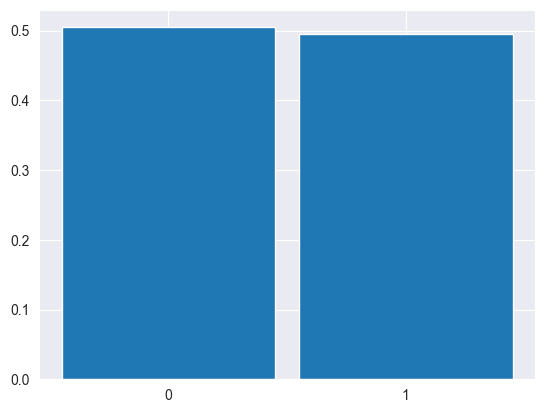

In [74]:
az.plot_dist(pred_dists[1].posterior_predictive['y_obs']);

In [43]:
idata = pm.sample_prior_predictive(1000, bb_model)

Sampling: [y_obs, θ]


In [51]:
idata.prior['y_obs']

KeyError: 'y_obs'